### ARIMA 모형

- arima 모형은 autoregressive integrated moving average라는 뜻
- arima모형이 과거의 데이터들을 사용하는것에 반해 arima모형은 이것을 넘어서서 과거의 데이터가 지니고 있던 추세(momentum)까지 반영하게 된다. 즉, correlation 뿐 아니라 cointegration까지 고려한 모델이다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('exchange_data/set01.csv', header=0, squeeze=True)

In [3]:
data = data.set_index('Date')

In [4]:
#2018년 2월~2019년1월 train set/ 2019년 2월 test set
df_train=data.loc['2018-02-01': '2019-01-31' ]
df_test=data.loc['2019-02-01':]

### 모수 설정

- ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag을 의미하는 p, MA모형의 Lag을 의미하는 q, 차분(Diffrence)횟수를 의미하는 d 가 그것이다.
- p * q = 0 이라 하면, 두 값중 하나는 0이라는 이야기이다. ARIMA는 AR모형과 MA모형을 하나로 합쳤다면서 둘 중 하나의 모수가 0이다. 실제로 대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에, 이렇게 사용하는것이 더 잘 맞는다고 한다.

- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고eq_yt와 eq_ytk 두 관측치의 관련성을 측정하는 함수

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

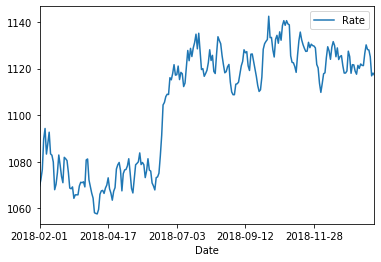

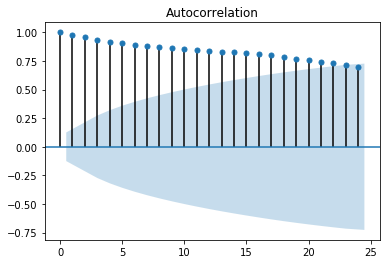

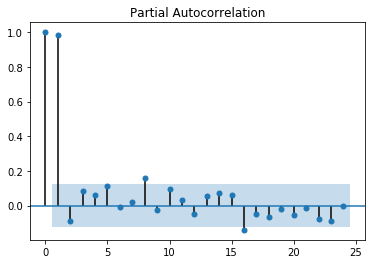

In [5]:
df_train.plot()
plot_acf(df_train)
plot_pacf(df_train)
plt.show()

- ACF를 보면 20의 Time lag을 기준으로 자기상관이 양에서 음으로 변동한다.(수정해야함) 
- 또한 PACF는 2의 Time lag에서 약 0.9를 보이고 이후에 급격히 감소한다. 
- 따라서 p=(수정해야함), q=2이 적당하다고 추측할 수 있다.

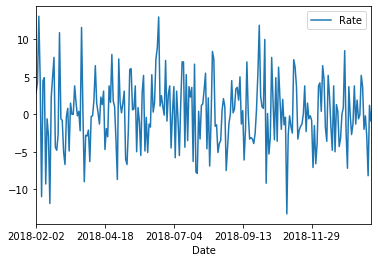

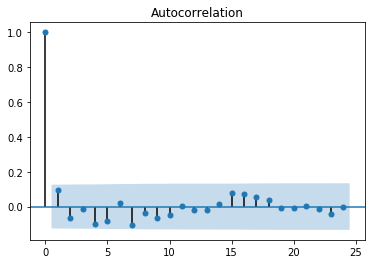

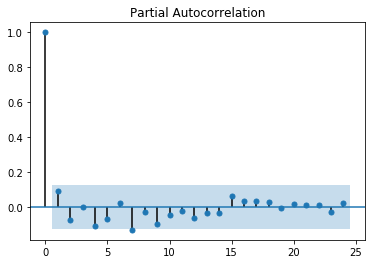

In [6]:
diff_1=df_train.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 차분이후의 ACF와 PACF를 보니, 시계열이 정상상태(Stationary)를 보이는것으로 생각되므로, 1차차분 만으로 충분할것같다.
- 따라서 본 데이터에는 ARIMA(0,1,1)을 사용하기로 한다

### 모형구축

- ARIMA(0,1,1)에서 다양하게 파라미터 변경하여 모수를 찾고 모델을 설정

In [7]:
model = ARIMA(df_train, order=(1,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                  244
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -713.472
Method:                       css-mle   S.D. of innovations              4.505
Date:                Thu, 06 Feb 2020   AIC                           1434.944
Time:                        13:02:46   BIC                           1448.933
Sample:                             1   HQIC                          1440.578
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1949      0.311      0.626      0.532      -0.415       0.805
ar.L1.D.Rate    -0.3870      0.292     -1.324      0.187      -0.960       0.186
ma.L1.D.Rate     0.4972      0.272      1.82

C:\Users\sm.woo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sm.woo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 예측

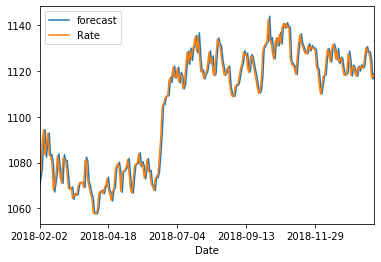

In [8]:
model_fit.plot_predict()
plt.show()

In [9]:
# 예측값, stderr, upper bound, lower bound
pred = model_fit.forecast(steps=len(df_test))

In [10]:
pred_price=pred[0]

In [11]:
print(pred_price.shape, df_test.shape)

(17,) (17, 1)


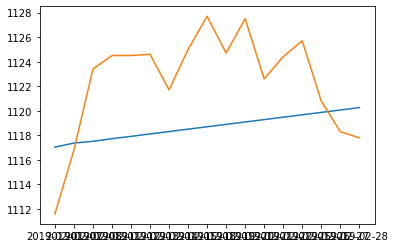

In [12]:
plt.plot(pred_price)
plt.plot(df_test)
plt.show()

In [20]:
actual_price=df_test['Rate'].tolist()

In [25]:
RMSE = mean_squared_error(pred_price, actual_price)**0.5    
print("RMSE =" ,RMSE)

RMSE = 5.513047097010294
